In [89]:
import urllib.request

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
urllib.request.urlretrieve(url, 'car.data')

('car.data', <http.client.HTTPMessage at 0x7f99688cfe80>)

In [90]:
import numpy as np
data = np.loadtxt("car.data",dtype='str',delimiter=',')
X, y = data[:,:-1], data[:,-1]
X.shape, y.shape

((1728, 6), (1728,))

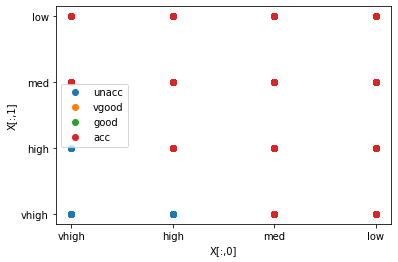

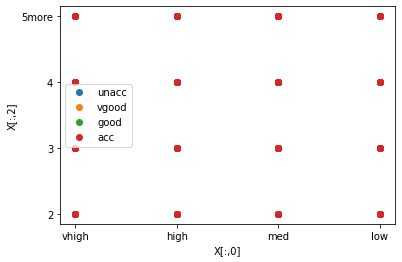

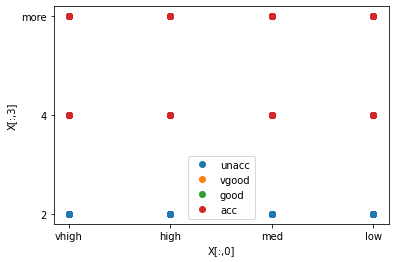

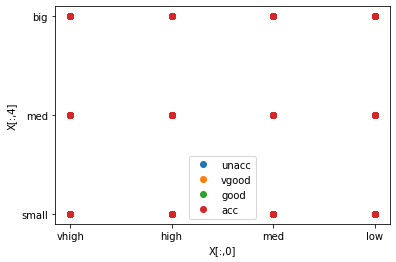

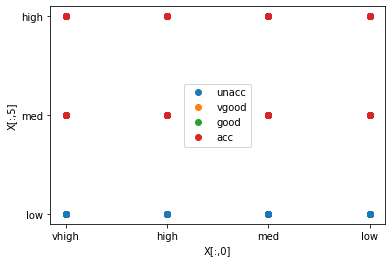

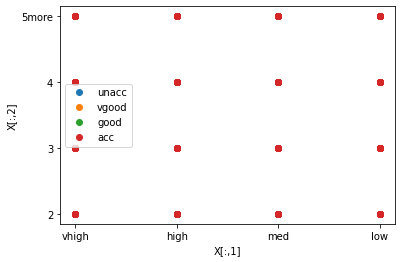

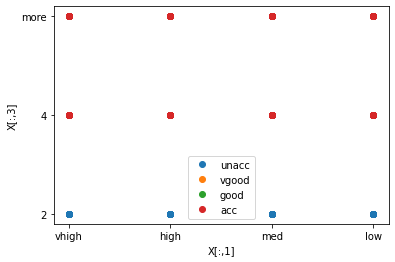

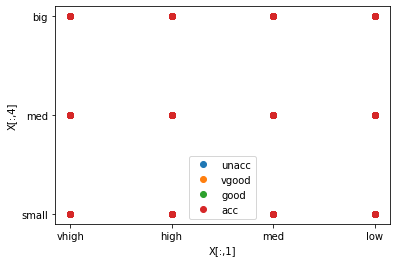

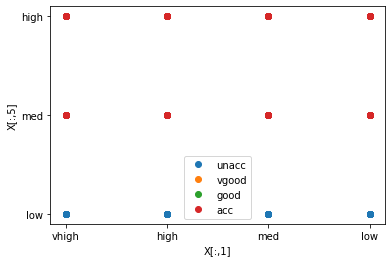

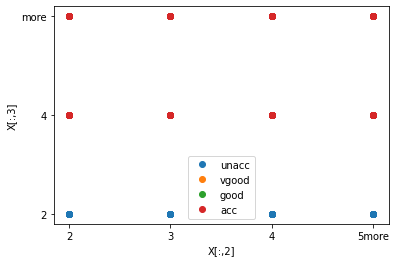

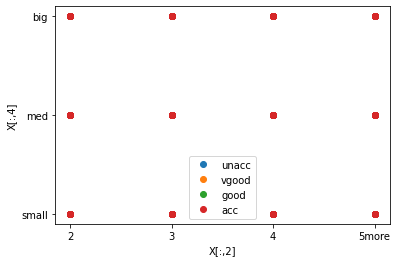

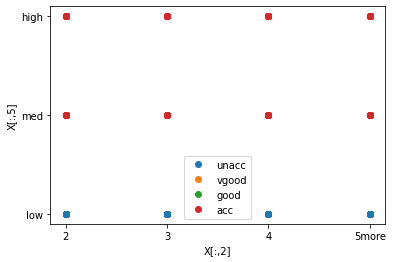

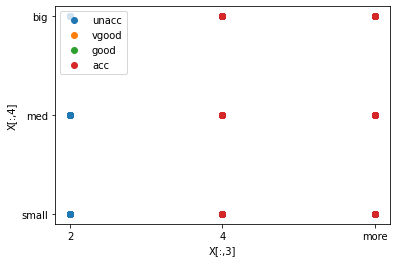

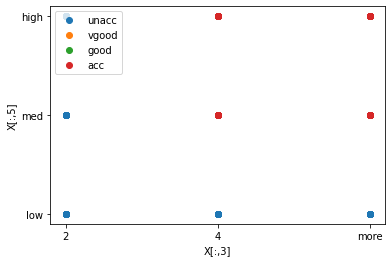

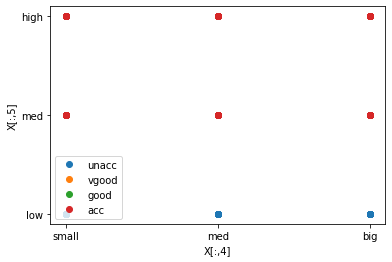

In [92]:
import matplotlib.pyplot as plt
for i in range(X.shape[1]):
    for j in range(i+1,X.shape[1]):
        plt.xlabel(f"X[:,{i}]")
        plt.ylabel(f"X[:,{j}]")
        for k in set(y):
            plt.plot(X[:,i][y==k], X[:,j][y==k], "o", label=k)
        plt.legend()
        plt.show()

In [109]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5')
        y[:] = self.resposta
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.7002314814814815, array([ True,  True,  True, ...,  True, False, False]))

In [150]:
class Arvore():
    def fit(self, X, y):
        self.caracteristica = 0
        self.resposta = maisFrequente(y)
        frequentes = y == self.resposta
        self.valorMaisFrequente = maisFrequente(X[frequentes, self.caracteristica])
        iguais = X[:,self.caracteristica] == self.valorMaisFrequente
        print(self.resposta, len(y), self.valorMaisFrequente)
        if sum(~iguais) > 0:
            self.diferente = Arvore()
            self.diferente.fit(X[~iguais,:], y[~iguais])
    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5')
        iguais = X[:,self.caracteristica] == self.valorMaisFrequente
        y[iguais] = self.resposta
        if sum(~iguais) > 0:
            y[~iguais] = self.diferente.predict(X[~iguais,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)
np.stack((ypred, y)).T

unacc 1728 vhigh
unacc 1296 high
unacc 864 med
unacc 432 low


array([['unacc', 'unacc'],
       ['unacc', 'unacc'],
       ['unacc', 'unacc'],
       ...,
       ['unacc', 'unacc'],
       ['unacc', 'good'],
       ['unacc', 'vgood']], dtype='<U5')